In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import xgboost as xgb
# from xgboost import plot_importance
#
# import xgboost as xgb

from sklearn import tree

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier

import shap

path = "/Users/conorosully/Google Drive/My Drive/Medium/AF - Measuring Bias/{}"

/home/ehsanap/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
         'marital-status', 'occupation', 'relationship', 'race', 'sex',
         'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
         'y']

#Load dataset
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
df = pd.read_csv("data/adult.csv", names=names, na_values='?')
df = df.dropna()

df = df.iloc[1:]

print(len(df))
df.head()

45222


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
1,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
2,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
3,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
4,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
6,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [3]:
df[['age', 'education-num', 'marital-status', 'occupation',
    'hours-per-week', 'native-country',
    'race', 'sex', 'y']].head(10)

,age,education-num,marital-status,occupation,hours-per-week,native-country,race,sex,y
1,25,7,Never-married,Machine-op-inspct,40,United-States,Black,Male,<=50K
2,38,9,Married-civ-spouse,Farming-fishing,50,United-States,White,Male,<=50K
3,28,12,Married-civ-spouse,Protective-serv,40,United-States,White,Male,>50K
4,44,10,Married-civ-spouse,Machine-op-inspct,40,United-States,Black,Male,>50K
6,34,6,Never-married,Other-service,30,United-States,White,Male,<=50K
8,63,15,Married-civ-spouse,Prof-specialty,32,United-States,White,Male,>50K
9,24,10,Never-married,Other-service,40,United-States,White,Female,<=50K
10,55,4,Married-civ-spouse,Craft-repair,10,United-States,White,Male,<=50K
11,65,9,Married-civ-spouse,Machine-op-inspct,40,United-States,White,Male,>50K
12,36,13,Married-civ-spouse,Adm-clerical,40,United-States,White,Male,<=50K


# Exploratory analysis


# Unbalanced datasets

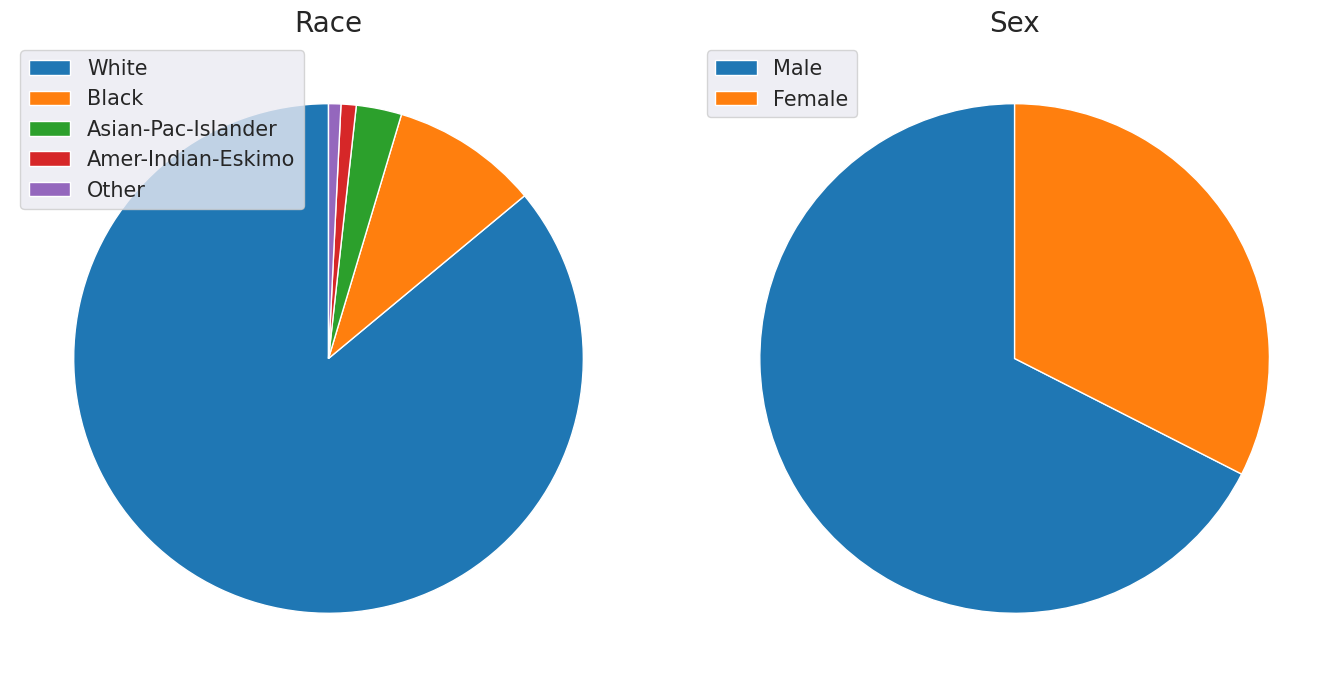

In [25]:
plt.figure(figsize=(14, 7))
plt.subplot(121)

#Plot breakdown by race
counts = df['race'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2, fontsize=15)
plt.title("Race", size=20)

plt.subplot(122)

#Plot breakdown by sex
counts = df['sex'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2, fontsize=15)
plt.title("Sex", size=20)

plt.tight_layout(pad=2)
# plt.savefig(path.format('unbalnced_datsets.png'),format='png',dpi=150)

# Defining protected features


In [5]:
df_fair = df[['race', 'sex']]

#Define protected variables
df_fair['priv_race'] = [1 if r == 'White' else 0 for r in df_fair['race']]
df_fair['priv_sex'] = [1 if s == 'Male' else 0 for s in df_fair['sex']]

#Define target variable
df_fair['y'] = [1 if y == '>50K' else 0 for y in df['y']]

df_fair.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,race,sex,priv_race,priv_sex,y
1,Black,Male,0,1,0
2,White,Male,1,1,0
3,White,Male,1,1,1
4,Black,Male,0,1,1
6,White,Male,1,1,0


# Prevelance

In [6]:
prev = df_fair['y'].mean()
prev_race = df_fair.groupby('priv_race')['y'].mean()
prev_sex = df_fair.groupby('priv_sex')['y'].mean()
prev_comb = df_fair.groupby(['priv_race', 'priv_sex'])['y'].mean()

print(prev)
print(prev_race)
print(prev_sex)
print(prev_comb)

0.2478439697492371
priv_race
0    0.158411
1    0.262371
Name: y, dtype: float64
priv_sex
0    0.113576
1    0.312477
Name: y, dtype: float64
priv_race  priv_sex
0          0           0.076102
           1           0.224408
1          0           0.122444
           1           0.323908
Name: y, dtype: float64


# Proxy Variable

In [7]:
y = [1 if y == '>50K' else 0 for y in df['y']]

X = df[['age', 'education-num', 'hours-per-week']]
X['marital-status'] = [1 if x == 'Married-civ-spouse' else 0 for x in df['marital-status']]
X['native-country'] = [1 if x == 'United-States' else 0 for x in df['native-country']]

occ_groups = {
    'Priv-house-serv': 0, 'Other-service': 0, 'Handlers-cleaners': 0,
    'Farming-fishing': 1, 'Machine-op-inspct': 1, 'Adm-clerical': 1,
    'Transport-moving': 2, 'Craft-repair': 2, 'Sales': 2,
    'Armed-Forces': 3, 'Tech-support': 3, 'Protective-serv': 3,
    'Prof-specialty': 4, 'Exec-managerial': 4}


X['occupation'] = [occ_groups[x] for x in df['occupation']]

# def filter(x):
#     if x.strip() == 'Priv-house-serv'.strip() or x.strip() == 'Other-service'.strip() or x.strip() == 'Handlers-cleaners'.strip():
#         return 0
#     if x.strip() == 'Adm-clerical'.strip():
#         return 1
#     if x.strip() == 'Transport-moving'.strip() or x.strip() == 'Craft-repair'.strip() or x.strip() == 'Sales'.strip():
#         return 2
#     if x.strip() == 'Armed-Forces'.strip() or x.strip() == 'Tech-support'.strip() or x.strip() == 'Protective-serv'.strip():
#         return 3
#     if x.strip() == 'Prof-specialty'.strip() or x.strip() == 'Exec-managerial'.strip():
#         return 4
#     else:
#         return 5
#
#
# X['occupation'] = df['occupation'].apply(filter)

X


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,age,education-num,hours-per-week,marital-status,native-country,occupation
1,25,7,40,0,1,1
2,38,9,50,1,1,1
3,28,12,40,1,1,3
4,44,10,40,1,1,1
6,34,6,30,0,1,0
...,...,...,...,...,...,...
48838,27,12,38,1,1,3
48839,40,9,40,1,1,1
48840,58,9,40,0,1,1
48841,22,9,20,0,1,1


([<matplotlib.axis.XTick at 0x7f6862da9ac0>,
 [Text(0, 0, 'age'),
  Text(1, 0, 'education-num'),
  Text(2, 0, 'hours-per-week'),
  Text(3, 0, 'marital-status'),
  Text(4, 0, 'native-country'),
  Text(5, 0, 'occupation')])

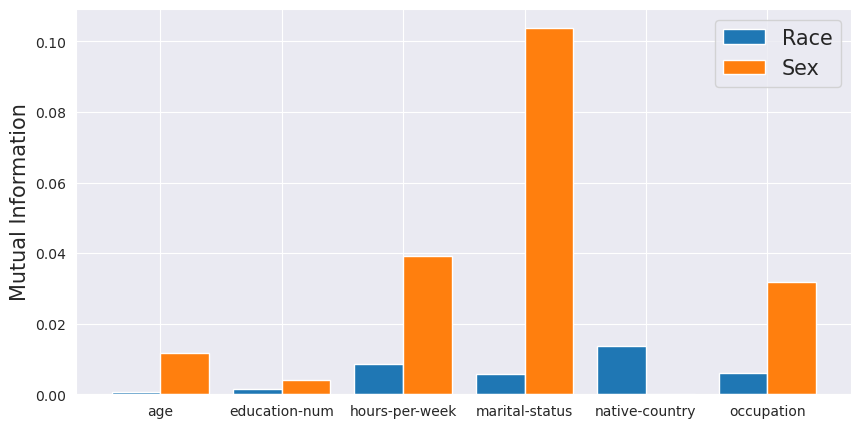

In [8]:
#Mutual information

#Calcualte mutual information

mut_race = mutual_info_classif(X, df_fair['priv_race'], discrete_features=[1, 3, 4, 5])
mut_sex = mutual_info_classif(X, df_fair['priv_sex'], discrete_features=[1, 3, 4, 5])

#Plot mutual information
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
          'native-country', 'occupation']
x = np.arange(len(labels))
width = 0.4
plt.bar(x - width / 2, height=mut_race, width=width, label='Race')
plt.bar(x + width / 2, height=mut_sex, width=width, label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Mutual Information', size=15)
plt.xticks(ticks=x, labels=labels)

# plt.savefig(path.format("Mutual_information.png"),dpi=100)

# Measuring fairness


# Modelling

In [9]:
y_race_0 = df_fair[df_fair['priv_race'] == 0]['priv_race']
y_race_1 = df_fair[df_fair['priv_race'] == 1]['priv_race']
y_race_1 = y_race_1.sample(len(y_race_0))
y_race = y_race_0.append(y_race_1)

X_race = X.loc[y_race.index]

# X_race

from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
X_race['age'] = lbl.fit_transform(X_race['age'].astype(int))
X_race['hours-per-week'] = lbl.fit_transform(X_race['hours-per-week'].astype(int))
X_race['education-num'] = lbl.fit_transform(X_race['education-num'].astype(int))

print(X_race.dtypes)
print(y_race.dtypes)

# Train model and get predictions
model = XGBClassifier()
model.fit(X_race, y_race)
y_pred = model.predict(X_race)

#Calculate accuracy
acc_race = accuracy_score(y_race, y_pred)

#Get feature importance
fi_race = model.get_booster().get_score(importance_type='weight')

#Output results
print(acc_race)
print(confusion_matrix(y_race, y_pred))
print(classification_report(y_race, y_pred))

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


age               int64
education-num     int64
hours-per-week    int64
marital-status    int64
native-country    int64
occupation        int64
dtype: object
int64
[19:14:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7294666877670517
[[4655 1664]
 [1755 4564]]
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      6319
           1       0.73      0.72      0.73      6319

    accuracy                           0.73     12638
   macro avg       0.73      0.73      0.73     12638
weighted avg       0.73      0.73      0.73     12638



In [10]:
y_sex_0 = df_fair[df_fair['priv_sex'] == 0]['priv_sex']
y_sex_1 = df_fair[df_fair['priv_sex'] == 1]['priv_sex']
y_sex_1 = y_sex_1.sample(len(y_sex_0))
y_sex = y_sex_0.append(y_sex_1)

X_sex = X.loc[y_sex.index]

from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
X_sex['age'] = lbl.fit_transform(X_sex['age'].astype(int))
X_sex['hours-per-week'] = lbl.fit_transform(X_sex['hours-per-week'].astype(int))
X_sex['education-num'] = lbl.fit_transform(X_sex['education-num'].astype(int))

print(X_sex.dtypes)

#Train model and get predictions
model = XGBClassifier()
model.fit(X_sex, y_sex)

y_pred = model.predict(X_sex)

#Calculate accuracy
acc_sex = accuracy_score(y_sex, y_pred)

#Get feature importance
fi_sex = model.get_booster().get_score(importance_type='weight')

#Output results
print(acc_sex)
print(confusion_matrix(y_sex, y_pred))
print(classification_report(y_sex, y_pred))

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


age               int64
education-num     int64
hours-per-week    int64
marital-status    int64
native-country    int64
occupation        int64
dtype: object
[19:14:49] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7913576046274243
[[12481  2214]
 [ 3918 10777]]
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     14695
           1       0.83      0.73      0.78     14695

    accuracy                           0.79     29390
   macro avg       0.80      0.79      0.79     29390
weighted avg       0.80      0.79      0.79     29390



([<matplotlib.axis.XTick at 0x7f6860499460>,
 [Text(0, 0, 'age'),
  Text(1, 0, 'education-num'),
  Text(2, 0, 'hours-per-week'),
  Text(3, 0, 'marital-status'),
  Text(4, 0, 'native-country'),
  Text(5, 0, 'occupation')])

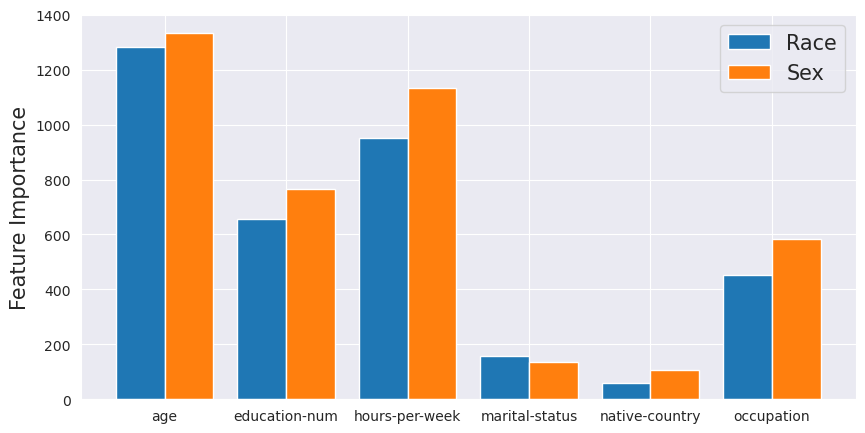

In [12]:
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
          'native-country', 'occupation']

fi_race = [fi_race[l] for l in labels]
fi_sex = [fi_sex[l] for l in labels]


x = np.arange(len(labels))
width = 0.4
plt.bar(x - width / 2, height=fi_race, width=width, label='Race')
plt.bar(x + width / 2, height=fi_sex, width=width, label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Feature Importance', size=15)
plt.xticks(ticks=x, labels=labels)

# plt.savefig(path.format("Feature Importance.png"), dpi=100)

# Measuring fairness


# Modelling

In [14]:
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
X['age'] = lbl.fit_transform(X['age'].astype(int))
X['hours-per-week'] = lbl.fit_transform(X['hours-per-week'].astype(int))
X['education-num'] = lbl.fit_transform(X['education-num'].astype(int))

model = XGBClassifier()
model.fit(X, y)

#Get predictions
y_pred = model.predict(X)
df_fair['y_pred'] = y_pred

print(confusion_matrix(y, y_pred))
print(accuracy_score(y, y_pred))
print(classification_report(y, y_pred))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[19:22:00] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[31494  2520]
 [ 4436  6772]]
0.8461810623148025
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     34014
           1       0.73      0.60      0.66     11208

    accuracy                           0.85     45222
   macro avg       0.80      0.77      0.78     45222
weighted avg       0.84      0.85      0.84     45222




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Feasures of Fairness


In [15]:
def fairness_metrics(df):
    """Calculate fairness for subgroup of population"""

    #Confusion Matrix
    cm=confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()

    N = TP+FP+FN+TN

    # Overall accuracy
    ACC = (TP+TN)/N

    # True positive rate
    TPR = TP/(TP+FN)

    # False positive rate
    FPR = FP/(FP+TN)

    # False negative rate
    FNR = FN/(TP+FN)

    # Percentage predicted as positive
    PPP = (TP + FP)/N

    return np.array([ACC, TPR, FPR, FNR, PPP])

In [16]:
fm_race_1 = fairness_metrics(df_fair[df_fair.priv_race==1])
fm_race_0 = fairness_metrics(df_fair[df_fair.priv_race==0])

#Get ratio of fairness metrics
fm_race = fm_race_0/fm_race_1

print(fm_race_1)
print(fm_race_0)
print(fm_race)

[0.83852145 0.61114921 0.08060357 0.38885079 0.2198031 ]
[0.89333755 0.53346653 0.03892441 0.46653347 0.11726539]
[1.06537233 0.87289082 0.48291172 1.19977503 0.53350198]


In [17]:
fm_sex_1 = fairness_metrics(df_fair[df_fair.priv_sex==1])
fm_sex_0 = fairness_metrics(df_fair[df_fair.priv_sex==0])


#Get ratio of fairness metrics
fm_sex = fm_sex_0/fm_sex_1

print(fm_sex_1)
print(fm_sex_0)
print(fm_sex)

[0.81000426 0.63245623 0.10930055 0.36754377 0.27277492]
[0.92133379 0.44278011 0.01734992 0.55721989 0.06566859]
[1.13744314 0.70009605 0.15873584 1.51606405 0.24074279]


# Additional analysis


In [19]:
df_fair['marital-status'] = X['marital-status']

#Calculate figures
count_ms = df_fair.groupby(['priv_sex','marital-status'])['priv_sex'].count()
prev_ms = df_fair.groupby(['marital-status'])['y'].mean()
prev_sex = df_fair.groupby(['priv_sex'])['y'].mean()

print(count_ms)
print(prev_ms)
print(prev_sex)

priv_sex  marital-status
0         0                 12482
          1                  2213
1         0                 11685
          1                 18842
Name: priv_sex, dtype: int64
marital-status
0    0.068027
1    0.454239
Name: y, dtype: float64
priv_sex
0    0.113576
1    0.312477
Name: y, dtype: float64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Archive

In [20]:
shape, scale = 2., 2.  # mean=4, std=2*sqrt(2)
r = np.random.gamma(3, 0.5, 1000)
r = (r-min(r))/(max(r)-min(r))
r = 16 + 60*r

nr = np.random.gamma(5, 1, 5000)
nr = (nr-min(nr))/(max(nr)-min(nr))
nr = 18 + 62*nr

In [21]:
avg_r = np.mean(r)
avg_nr = np.mean(nr)
avg_t = np.mean([*r,*nr])
print(avg_t,avg_nr,avg_r)

33.04662832510934 33.57600317765795 30.39975406236631


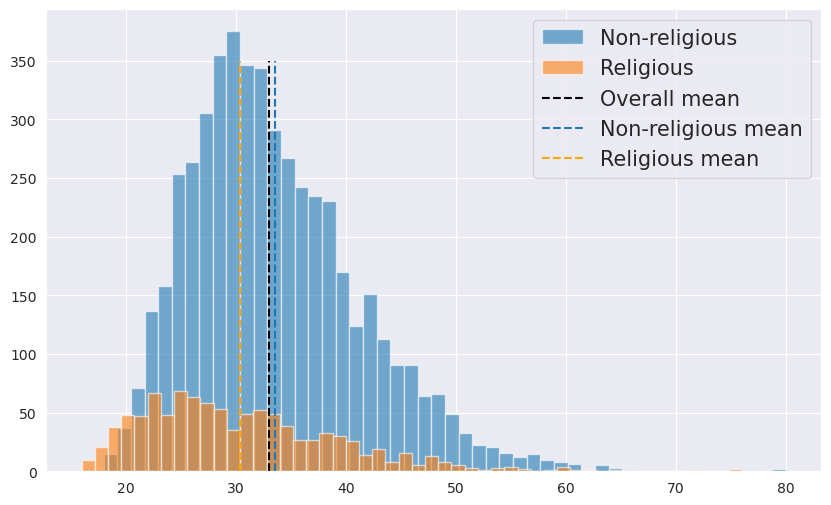

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(nr, 50,label='Non-religious',alpha = 0.6)
plt.hist(r, 50,label='Religious',alpha = 0.6)

plt.vlines(x=avg_t,ymin=0,ymax=350,colors='Black',linestyles='--', label= 'Overall mean')
plt.vlines(x=avg_nr,ymin=0,ymax=350,colors='#1F77B4',linestyles='--', label= 'Non-religious mean')
plt.vlines(x=avg_r,ymin=0,ymax=350,colors='Orange',linestyles='--', label= 'Religious mean')

plt.legend(prop={'size': 15})
# plt.savefig(path.format('skew_example.png'),format='png',dpi=150)